# Natural Language Processing with Tensorflow

This notebook contains:
  * Downloading a text dataset
  * Visualizing the data
  * Converting text into numbers using tokenization
  * Turning tokenized text into an embedding
  * Modelling a text data
    * Starting with a baseline (TF-IDF)
    * Building several deep learning text models
      * Dense, LSTM, GRU, Conv1D, Transfer Learning
  * Comparing the performance of each of our models
  * Combining our models into an ensemble
  * Saving and loading a trained model
  * Finding the most wrong predictions

## Checking the GPU

In [98]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ce82ae6b-176a-1242-f1a6-eaa28db7d3a8)


## Get helper functions

In [99]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-13 18:41:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-13 18:41:39 (87.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [100]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Download a text dataset

In [101]:
# Download data
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2023-02-13 18:41:40--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2023-02-13 18:41:40 (133 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [102]:
# Unzip data
unzip_data("nlp_getting_started.zip")

# Visualizing the dataset

In [103]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [104]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [105]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [106]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [107]:
# How many samples total
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df)+len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [108]:
# Visualizing some random samples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text: {text}")
  print("---")

Target: 1 (real disaster)
Text: The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d
---
Target: 0 (not real disaster)
Text: Save your riches in heaven where they will never decrease because no thief can gets them and no moth can destroy them. ??
---
Target: 0 (not real disaster)
Text: @ArianaGrande @justinbieber OMGGGG IM SCREAMING
---
Target: 0 (not real disaster)
Text: #Kick Hendrixonfire  @'=BLACKCATS= | BIG NOOB CONQUEST | MIXED MAPS | ALL WEAPONS' for violated K/DR  Limit /Server  max 3
---
Target: 0 (not real disaster)
Text: @brookesddl I am traumatised the lil shit nearly hopped in the bloody shower with me
---


### Split the data into training and validation sets

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df_shuffled['text'].to_numpy(), train_df_shuffled['target'].to_numpy(), test_size=0.1, random_state=42)

In [110]:
# Check the sizes of train and val sets
len(X_train), len(X_val), len(y_train), len(y_val)

(6851, 762, 6851, 762)

# Converting Text into Numbers

### Text Vectorization

In [111]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

In [112]:
# Find average number of tokens in training Tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [113]:
#@title Default title text
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                   output_mode="int",
                                   output_sequence_length=max_length)

In [114]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [115]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [116]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\nVectorized text: \n{text_vectorizer(random_sentence)}")

Original text:
FAAN orders evacuation of abandoned aircraft at MMA http://t.co/GsOMtDPmoJ
Vectorized text: 
[1679 1268  245    6 1441  661   17 2041    1    0    0    0    0    0
    0]


In [117]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

In [118]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length="max_length",
                             name="embedding_1")

embedding

In [119]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\nEmbedded version:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@BlossomingLilac so destruction it seems. I see myself ruined... somehow.
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01626083,  0.01490286,  0.02943394, ..., -0.03494666,
         -0.0177719 ,  0.02818533],
        [ 0.00213159,  0.03731548, -0.04958695, ..., -0.03925953,
         -0.02588996,  0.02669736],
        [ 0.04149357, -0.00489552,  0.00993389, ..., -0.04142589,
          0.00522697, -0.0460658 ],
        ...,
        [-0.0395567 , -0.00392898,  0.01914519, ..., -0.04817969,
         -0.02258171, -0.01591027],
        [-0.0395567 , -0.00392898,  0.01914519, ..., -0.04817969,
         -0.02258171, -0.01591027],
        [-0.0395567 , -0.00392898,  0.01914519, ..., -0.04817969,
         -0.02258171, -0.01591027]]], dtype=float32)>

In [120]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 1.62608288e-02,  1.49028562e-02,  2.94339396e-02, -1.92382578e-02,
        2.80804895e-02, -3.92644517e-02, -4.64331992e-02, -4.82809208e-02,
        2.21665613e-02,  2.58653238e-03,  2.26127543e-02, -2.75540836e-02,
       -1.55828372e-02, -4.20163870e-02,  2.51855887e-02,  1.44119747e-02,
       -1.02886446e-02, -3.70653979e-02,  4.56796326e-02,  4.21930440e-02,
        3.18121947e-02,  1.45598762e-02,  4.56172265e-02,  1.76769607e-02,
       -2.67225746e-02,  4.59963717e-02, -4.40299287e-02, -1.55323371e-02,
       -8.63359123e-03, -1.03257895e-02,  3.43443044e-02, -4.55359109e-02,
        4.04996797e-03, -4.69732545e-02,  5.80454990e-03, -2.70934701e-02,
       -6.21093437e-03,  3.33798192e-02,  4.23885845e-02, -4.74666730e-02,
       -2.73628961e-02,  2.04945914e-02, -3.32085975e-02, -4.10107262e-02,
       -2.01154947e-02,  1.52835585e-02,  3.54278423e-02, -1.22833028e-02,
       -3.95468473e-02, -2.39444263e-02,  3.51109765

# Modelling a text dataset

* **Model 0**: Naive bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: Tensorflow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

### Model 0: Getting a baseline

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [122]:
baseline_score = model_0.score(X_val, y_val)
print(f"Our baseline model achieves the accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves the accuracy of: 79.27%


In [123]:
# Make predictions
baseline_preds = model_0.predict(X_val)
baseline_preds[:20]


array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments
  * Accuracy
  * Precision
  * Recall
  * F1-Score

In [124]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1":model_f1}
  return model_results

In [125]:
# Get baseline results
baseline_results = calculate_results(y_true=y_val, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A Simple dense model

In [126]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [127]:
# Build model with the functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [128]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [129]:
# Get summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [130]:
# Fit the model
model_1.history = model_1.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=[X_val, y_val],
                              callbacks=[create_tensorboard_callback(dir_name="SAVE_DIR",
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: SAVE_DIR/simple_dense_model/20230213-184142
Epoch 1/5
215/215 [==============================] - 14s 58ms/step - loss: 0.6094 - accuracy: 0.6958 - val_loss: 0.5361 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4414 - accuracy: 0.8190 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3465 - accuracy: 0.8609 - val_loss: 0.4590 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2849 - accuracy: 0.8921 - val_loss: 0.4641 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2380 - accuracy: 0.9121 - val_loss: 0.4766 - val_accuracy: 0.7861


In [131]:
# Check the results
model_1.evaluate(X_val, y_val)

24/24 [==============================] - 0s 3ms/step - loss: 0.4766 - accuracy: 0.7861


[0.4765534996986389, 0.7860892415046692]

In [132]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-2.64346637e-02, -1.79888643e-02,  3.16241980e-02, ...,
         -6.33905828e-02, -3.76096442e-02, -3.04413885e-02],
        [ 1.82592627e-02,  1.22270379e-02,  3.04779466e-02, ...,
         -3.83756496e-02, -2.11484153e-02,  2.50219777e-02],
        [-1.89419966e-02, -2.95040160e-02, -2.68138610e-02, ...,
         -1.60648618e-02,  1.65170357e-02, -1.66146364e-02],
        ...,
        [-2.87309177e-02,  4.87870239e-02, -1.21510141e-02, ...,
          2.09076069e-02,  4.67827804e-02, -2.80284882e-03],
        [ 2.70557906e-02, -7.64035434e-02,  8.26090854e-03, ...,
          1.31249987e-02, -3.09024248e-02, -8.53670281e-05],
        [ 9.48428288e-02, -9.33259130e-02,  1.17257446e-01, ...,
         -4.40671891e-02, -2.09067240e-02, -4.43399101e-02]], dtype=float32)>]

In [133]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [134]:
# Make predictions
model_1_pred_probs = model_1.predict(X_val)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.4142558 ],
       [0.7472602 ],
       [0.9979005 ],
       [0.10827291],
       [0.10103557],
       [0.9376115 ],
       [0.9157755 ],
       [0.99278885],
       [0.9687065 ],
       [0.2640798 ]], dtype=float32)

In [135]:
# Turn prediction probabilities into single dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [136]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true = y_val, y_pred = model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

### Model 2: LSTM

In [137]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
# x = layers.Dense(1, activation="sigmoid")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)


In [138]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [139]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [140]:
# Fit the model
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230213-184206
Epoch 1/5
215/215 [==============================] - 17s 66ms/step - loss: 0.5083 - accuracy: 0.7431 - val_loss: 0.4568 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3166 - accuracy: 0.8710 - val_loss: 0.5145 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2204 - accuracy: 0.9169 - val_loss: 0.5740 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1574 - accuracy: 0.9454 - val_loss: 0.6236 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1122 - accuracy: 0.9596 - val_loss: 0.8471 - val_accuracy: 0.7546


In [141]:
# Make prediction on the validation dataset
model_2_pred_probs = model_2.predict(X_val)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.01804261],
        [0.734287  ],
        [0.9993556 ],
        [0.05935225],
        [0.00494473],
        [0.9995384 ],
        [0.9159097 ],
        [0.9997663 ],
        [0.99959356],
        [0.5584311 ]], dtype=float32))

In [142]:
# Round up predictions and reduce it to 1D array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [143]:
# Calculate LSTM model results
model_2_results = calculate_results(y_val, model_2_preds)
model_2_results

{'accuracy': 75.45931758530183,
 'precision': 0.7546642240189775,
 'recall': 0.7545931758530183,
 'f1': 0.7531886844350836}

### Model 3: GRU

In [144]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="GRU")

In [145]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [146]:
model_3.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________________

In [147]:
# Fit the model
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230213-184235
Epoch 1/5
215/215 [==============================] - 14s 51ms/step - loss: 0.5250 - accuracy: 0.7313 - val_loss: 0.4550 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.3196 - accuracy: 0.8697 - val_loss: 0.4940 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2194 - accuracy: 0.9177 - val_loss: 0.5571 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1578 - accuracy: 0.9450 - val_loss: 0.6168 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1199 - accuracy: 0.9602 - val_loss: 0.6008 - val_accuracy: 0.7743


In [148]:
# Make prediction on validation data
model_3_pred_probs = model_3.predict(X_val)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.31509137],
       [0.8950524 ],
       [0.9972475 ],
       [0.14975399],
       [0.01152571],
       [0.9898985 ],
       [0.75994325],
       [0.99663794],
       [0.99697435],
       [0.38262054]], dtype=float32)

In [149]:
# Round up the prediction and convert it to 1D array
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [150]:
# Calculate result
model_3_results = calculate_results(y_val, model_3_preds)
model_3_results

{'accuracy': 77.42782152230971,
 'precision': 0.7740592463511713,
 'recall': 0.7742782152230971,
 'f1': 0.7735154339779791}

### Model 4: Bidirectional RNN Model

In [151]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in tensorflow
input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(input)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
output = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(input, output, name="model_4_Bidirectional")

In [152]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [153]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [154]:
# Fit the model
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230213-184306
Epoch 1/5
215/215 [==============================] - 15s 46ms/step - loss: 0.5087 - accuracy: 0.7466 - val_loss: 0.4562 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3141 - accuracy: 0.8707 - val_loss: 0.5141 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.2119 - accuracy: 0.9174 - val_loss: 0.5596 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1467 - accuracy: 0.9517 - val_loss: 0.6627 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1033 - accuracy: 0.9650 - val_loss: 0.6815 - val_accuracy: 0.7612


In [155]:
# Make predictions with bidirectional RNN on validation data
model_4_pred_probs = model_4.predict(X_val)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.02954604],
       [0.90171474],
       [0.9994742 ],
       [0.14796557],
       [0.00411869],
       [0.9976584 ],
       [0.92646724],
       [0.9997961 ],
       [0.9996253 ],
       [0.26360086]], dtype=float32)

In [156]:
# Convert prediction probabilities to labels
model_4_pred = tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [157]:
# Calculate bidirection model results
model_4_results = calculate_results(y_val, model_4_pred)
model_4_results

{'accuracy': 76.11548556430446,
 'precision': 0.7608818684574628,
 'recall': 0.7611548556430446,
 'f1': 0.7602537798972311}

### Model 5: Conv1D (Convolutional Neural Network for Text)

In [158]:
# Test out the embedding, 1D Convolutional and max pooling
embedding_test = embedding(text_vectorizer(['This is a test sentence']))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [159]:
embedding_test[:1], max_pool_output[:1], conv_1d_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.05045488,  0.04324896,  0.01135573, ..., -0.04193433,
           0.02700617,  0.00112944],
         [ 0.05114131, -0.00480833,  0.01596773, ..., -0.00556507,
          -0.05081392, -0.03084903],
         [ 0.01437467, -0.02807466, -0.01175872, ..., -0.01696999,
          -0.03025133,  0.0104078 ],
         ...,
         [-0.02643466, -0.01798886,  0.0316242 , ..., -0.06339058,
          -0.03760964, -0.03044139],
         [-0.02643466, -0.01798886,  0.0316242 , ..., -0.06339058,
          -0.03760964, -0.03044139],
         [-0.02643466, -0.01798886,  0.0316242 , ..., -0.06339058,
          -0.03760964, -0.03044139]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 32), dtype=float32, numpy=
 array([[0.        , 0.06870638, 0.08531224, 0.02316569, 0.05092491,
         0.12069915, 0.        , 0.        , 0.        , 0.01869274,
         0.03262229, 0.09082417, 0.06752545, 0.0358077 , 0.03551643,
         0.08269417, 0.08518955

In [160]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [161]:
# model_5 summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1920      
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 1)              

In [162]:
# Compile model_5
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [163]:
# Fit the model
model_5_history = model_5.fit(X_train, y_train, epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230213-184352
Epoch 1/5
215/215 [==============================] - 8s 32ms/step - loss: 0.6400 - accuracy: 0.6304 - val_loss: 0.6217 - val_accuracy: 0.6470
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.6110 - accuracy: 0.6624 - val_loss: 0.6100 - val_accuracy: 0.6483
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.6003 - accuracy: 0.6739 - val_loss: 0.6127 - val_accuracy: 0.6496
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.5936 - accuracy: 0.6738 - val_loss: 0.6144 - val_accuracy: 0.6562
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.5867 - accuracy: 0.6802 - val_loss: 0.6196 - val_accuracy: 0.6627


In [164]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(X_val)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.41433483],
       [0.7656764 ],
       [0.771381  ],
       [0.2139772 ],
       [0.3213676 ],
       [0.76612085],
       [0.6791894 ],
       [0.41411483],
       [0.6948198 ],
       [0.38378295]], dtype=float32)

In [165]:
# Convert predictions to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 0., 1., 0.], dtype=float32)>

In [166]:
# Calculate model_5 results
model_5_results = calculate_results(y_val, model_5_preds)
model_5_results

{'accuracy': 66.27296587926509,
 'precision': 0.6698055960023097,
 'recall': 0.6627296587926509,
 'f1': 0.6499161892156957}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [167]:
# Example pof pre trained embedding with universal sentence encoder
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])


tf.Tensor(
[ 0.03596691 -0.08579467 -0.01152742  0.00525983 -0.01852173 -0.05042011
 -0.03616942  0.00534679  0.04805915  0.04690745 -0.03723331 -0.01149543
  0.04352415  0.0705099   0.07093762 -0.08180429  0.00871717 -0.04654123
 -0.02245775  0.04686872  0.00202255  0.03099073  0.02043564  0.06392168
 -0.07641087  0.08421177 -0.0457604  -0.00106165 -0.0205942   0.01241105
  0.05727538  0.03815621 -0.02742113 -0.00354348 -0.09832585 -0.01244854
  0.03865629  0.05031954 -0.02362505  0.00321848  0.03225213  0.00738092
  0.04473101 -0.00412239  0.01151604  0.02837726  0.00060137 -0.05903352
 -0.00494344 -0.0068853 ], shape=(50,), dtype=float32)


In [168]:
embed_samples[0].shape

TensorShape([512])

In [169]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         input_shape=[],
                                         dtype="string",
                                         trainable=False,
                                         name="USE")


In [170]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
    sentence_encoding_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["Accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [171]:
# Fit the model
model_6_history = model_6.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder"))

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230213-184424
Epoch 1/5
215/215 [==============================] - 7s 15ms/step - loss: 0.5015 - Accuracy: 0.7907 - val_loss: 0.4480 - val_Accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4148 - Accuracy: 0.8145 - val_loss: 0.4364 - val_Accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4005 - Accuracy: 0.8218 - val_loss: 0.4326 - val_Accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3936 - Accuracy: 0.8240 - val_loss: 0.4278 - val_Accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3877 - Accuracy: 0.8289 - val_loss: 0.4294 - val_Accuracy: 0.8150


In [172]:
# Make predictions
model_6_pred_probs = model_6.predict(X_val)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 17ms/step


array([[0.15675399],
       [0.73745143],
       [0.98646   ],
       [0.20211498],
       [0.72631055],
       [0.6870087 ],
       [0.98134345],
       [0.9731801 ],
       [0.92425776],
       [0.08272082]], dtype=float32)

In [173]:
# Convert probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [174]:
# Calculate model_6 results
model_6_results = calculate_results(y_val, model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8179063565195398,
 'recall': 0.8149606299212598,
 'f1': 0.8132300658103407}

### Comparing the performance of each of our models

In [175]:
# combine model results into a dataframe
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1D": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.459318,0.754664,0.754593,0.753189
gru,77.427822,0.774059,0.774278,0.773515
bidirectional,76.115486,0.760882,0.761155,0.760254
conv1D,66.272966,0.669806,0.662730,0.649916
tf_hub_sentence_encoder,81.496063,0.817906,0.814961,0.813230


In [176]:
# Reduce the accuracy to same scale as the other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

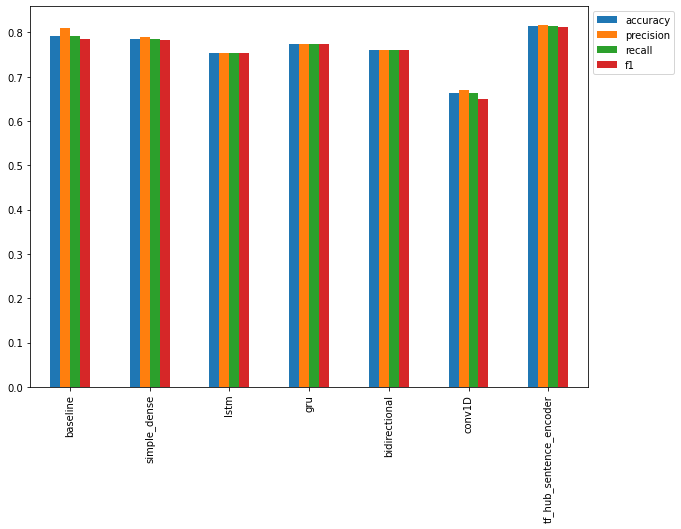

In [177]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

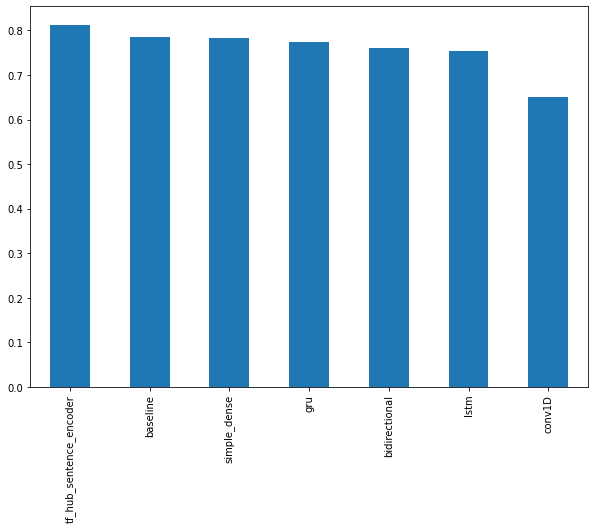

In [178]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

### Combining our models (model ensembling/stacking)

In [179]:
# Get mean and pred probs for 3 models
import numpy as np
baseline_pred_probs = np.max(model_0.predict_proba(X_val), axis=1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [180]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(y_val, combined_preds)
ensemble_results

{'accuracy': 77.69028871391076,
 'precision': 0.776582385307229,
 'recall': 0.7769028871391076,
 'f1': 0.7766079432462936}

In [181]:
# Add our combined model's results to the results dataframe
all_model_results.loc["ensemble_results"] = ensemble_results 

In [182]:
# Convert the accuracy to the same scale as rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [183]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.754593,0.754664,0.754593,0.753189
gru,0.774278,0.774059,0.774278,0.773515
bidirectional,0.761155,0.760882,0.761155,0.760254
conv1D,0.662730,0.669806,0.662730,0.649916
tf_hub_sentence_encoder,0.814961,0.817906,0.814961,0.813230
ensemble_results,0.776903,0.776582,0.776903,0.776608


### Saving and loading a trained model

In [184]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [185]:
# Load model with custom hub layer (required wit HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [186]:
# How does our loaded model perform
loaded_model_6.evaluate(X_val, y_val)

24/24 [==============================] - 1s 16ms/step - loss: 0.4294 - Accuracy: 0.8150


[0.4294082820415497, 0.8149606585502625]

In [187]:
# Save TF Hub Sentence Encoder model to SavedModel format
model_6.save("Model_6_SavedModel_format")

In [188]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("Model_6_SavedModel_format")

In [189]:
# Evaluate the loaded saved model
loaded_model_6_SavedModel.evaluate(X_train, y_train)

215/215 [==============================] - 3s 10ms/step - loss: 0.3742 - Accuracy: 0.8384


[0.37419256567955017, 0.8384177684783936]

### Finding the most wrong examples

In [190]:
# Create dataframe with validation sentences and best performing model prediction
val_df = pd.DataFrame({"text": X_val,
                       "target": y_val,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.156754
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.737451
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986460
3,@camilacabello97 Internally and externally scr...,1,0.0,0.202115
4,Radiation emergency #preparedness starts with ...,1,1.0,0.726311


In [191]:
# Find the wrong prediction and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.905139
759,FedEx will no longer transport bioterror patho...,0,1.0,0.856046
628,@noah_anyname That's where the concentration c...,0,1.0,0.844502
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.842994
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.837470
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.815127
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.790563
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.788012
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.776333
695,A look at state actions a year after Ferguson'...,0,1.0,0.767581


In [192]:
# Check the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {int(prob)}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/

In [193]:
# Check the false negatives
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {int(prob)}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

----

Target: 1, Pred: 0, Prob: 0
Te

### Making predictions on the test dataset

In [194]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n {test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 43ms/step
Pred: 1.0, Prob: 0.7460409998893738
Text:
 The Denver Post - Motorcyclist bicyclist injured in Denver collision on Broadway http://t.co/yjrIi5mHii

----

1/1 [==============================] - 0s 41ms/step
Pred: 1.0, Prob: 0.5645135641098022
Text:
 New US counter #terrorism program urges #Muslims to rat each other out critics say http://t.co/mVn6T9VhUl http://t.co/7lUfjX684i

----

1/1 [==============================] - 0s 42ms/step
Pred: 0.0, Prob: 0.07380304485559464
Text:
 Skate and Destroy em Taguatinga - Campeonatos de Skate http://t.co/xWW9dOPLK9

----

1/1 [==============================] - 0s 42ms/step
Pred: 0.0, Prob: 0.018196864053606987
Text:
 Check out the #new #ebook on #sale by #TimZak 'The Lizard Stuck in a #Blizzard' #rhyming #kidsbook on #Amazon http://t.co/kVZuxdL4ij

----

1/1 [==============================] - 0s 40ms/step
Pred: 0.0, Prob: 0.1954726129770279
Text:
 Con el Crack de Hazzel Hazard?????? @ Saint John's

### Predicting on Tweets from the wild

In [195]:
# Turn Tweet into string
tweet = "Life like an ensemble: thke the best choices from others and make your own"

In [197]:
def predict_on_sentence(model, sentence):
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(F"Pred: {pred_label}", "(real disaster)" if pred_label>0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [198]:
# Make prediction a Tweet from the wild
predict_on_sentence(model=model_6,
                    sentence=tweet)

1/1 [==============================] - 0s 50ms/step
Pred: 0.0 (not real disaster) Prob: 0.04041489586234093
Text:
Life like an ensemble: thke the best choices from others and make your own


In [199]:
beirut_tweet = "#Beirut declared a 'devastated city', two-week state of emergency officially declared. #Lebanon"

In [200]:
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet)

1/1 [==============================] - 0s 56ms/step
Pred: 1.0 (real disaster) Prob: 0.9699856042861938
Text:
#Beirut declared a 'devastated city', two-week state of emergency officially declared. #Lebanon


### The speed/score tradeoff

In [201]:
# Calculate the time of prediction
import time
def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  time_per_pred = total_time/len(X_val)
  return total_time, time_per_pred


In [203]:
# Calvulate TF Hub Sentence encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, X_val)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 20ms/step


(0.7646657340001184, 0.0010034983385828326)

In [204]:
# Calvulate Naiive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, X_val)
baseline_total_pred_time, baseline_time_per_pred

(0.0416826530004073, 5.4701644357489895e-05)

Text(0, 0.5, 'F1-score')

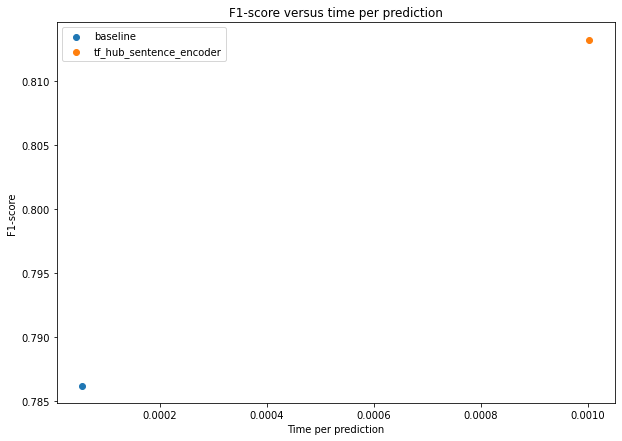

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")